### questions from TJC
 - can we get estimates/error bars from wihtin individuals when it comes to dating admixture
 - can we get individual admixture ages per country (maybe a boxplot).
 - test for selection consider using the same ones from the previous paper and/or iHS.

# Ancestry *S.haematobium* vs. *S. bovis* across Africa (SCAN)

Neal Platt 2021

# Prep envrinoment and data for analyses

use the `scan_selection` conda environment

In [1]:
import os
import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
import statsmodels.stats.multitest as smm
import scipy.stats as stats
from pathlib import Path
from matplotlib.colors import ListedColormap
# from itertools import groupby
# import seaborn as sns
# import pickle
# #from collections import Counter
# from IPython.display import Image 
# import glob
# #import pybedtools
# import gffutils
# from scipy.signal import medfilt
from collections import defaultdict
from intervaltree import Interval, IntervalTree
#import vcf
#import loter.locanc.local_ancestry as lc
from IPython.display import Image

In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir=f"{proj_dir}/results"
os.chdir(results_dir)

## Get sample info

In [3]:
sample_info_df = pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir))

In [4]:
sample_info_df

,admera_id,barcode_label_ID,library_id,sample_name,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon
0,19047FL-14-02-03,MCF03050E0612,na,sha_angola_cota_57,SRR11907442,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
1,19047FL-14-02-04,MCF03050E0613,na,sha_angola_cota_58,SRR11907441,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
2,19047FL-14-02-05,MCF03050E0614,na,sha_angola_cota_59,SRR11907440,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
3,19047FL-14-02-06,MCF03050E0615,na,sha_angola_icau_60,SRR11907439,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
4,19047FL-14-02-07,MCF03050E0615,na,sha_angola_icau_61,SRR11907438,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,na,na,na,sh_egypt_SRR433862,SRR433862,s_haematobium,egypt,na,na,haematobium,Rey_2019,genome,NaN,NaN
445,na,na,na,sh_gambia_SRR13579872,SRR13579872,s_haematobium,gambia,na,na,haematobium,Rey_2019,genome,NaN,NaN
446,na,na,na,sh_ivorycoast_SRR13579866,SRR13579866,s_haematobium,cote_d_ivoire,na,na,haematobium,Rey_2019,genome,NaN,NaN
447,na,na,na,sh_madagascar_SRR13579871,SRR13579871,s_haematobium,madagascar,na,na,haematobium,Rey_2019,genome,NaN,NaN


## Read in data and get allele counts

In [181]:
#read in the vcf file
filtered_callset=allel.read_vcf(f'{results_dir}/post_phase_filtering/autosomes_unrelated.vcf')

In [182]:
#get relevant info
gt      = allel.GenotypeArray(filtered_callset['calldata/GT'])
chroms  = filtered_callset["variants/CHROM"]
samples = filtered_callset["samples"]
poss    = filtered_callset["variants/POS"]
var_ids = filtered_callset["variants/ID"]

uniq_chroms=np.unique(chroms)

In [183]:
#read in pca df since it has species ids and kmeans labels
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
pca_df["country"] = pca_df["country"].astype(str)

In [184]:
pca_df.loc[ (pca_df["kmeans_label"] == "sh_nw") & 
            (pca_df["project"] == "scan_africa")]

,sample_name,1,2,3,4,5,6,7,8,9,...,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species,kmeans_label
29,sbo_cdivoire_raviart_108,0.021400,-0.070582,-0.045198,0.206487,0.004450,0.012315,0.028276,-0.103222,-0.100459,...,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0,s_haematobium,sh_nw
30,sbo_cdivoire_raviart_109,0.020538,-0.076418,-0.046554,0.226617,-0.003926,-0.014860,-0.011537,-0.087275,-0.110759,...,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0,s_haematobium,sh_nw
31,sbo_niger_libore_154,0.025617,-0.079330,-0.013864,-0.055163,-0.001331,-0.003984,0.000089,-0.016355,0.055014,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
32,sbo_niger_libore_155,0.021715,-0.077734,-0.013288,-0.061101,0.008696,-0.056704,0.051375,-0.009732,0.050136,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
33,sbo_niger_libore_160,0.021868,-0.075221,-0.018740,-0.071181,-0.001439,-0.055054,0.051839,-0.075687,0.004744,...,na,snail,unk,scan_africa,genome,13.388050,2.199130,0,s_haematobium,sh_nw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,ssp_niger_libore_166,0.022455,-0.078463,-0.021334,-0.066131,0.005504,-0.046551,0.052623,-0.059921,0.043647,...,na,snail,unk,scan_africa,genome,13.388050,2.199130,0,s_haematobium,sh_nw
166,ssp_niger_libore_167,0.023576,-0.078099,-0.011150,-0.061000,0.017043,-0.045486,0.040388,-0.017674,0.024366,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
167,ssp_niger_libore_168,0.022321,-0.076938,-0.018901,-0.060000,0.006243,-0.004137,0.029055,-0.042276,0.080228,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
168,ssp_niger_libore_169,0.023969,-0.073719,-0.019718,-0.050199,0.016409,-0.015895,0.038597,-0.020768,0.037634,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw


### Species

In [185]:
#get species idxs
sp_idxs = {}
sp_acs  = {}

for sp in tqdm(["s_bovis", "s_haematobium"]):
    
    #find indecies for each sample from that species
    names = pca_df.loc[pca_df["pca_species"] ==  sp, "sample_name"]
    sp_idxs[sp]=np.in1d(samples, names).nonzero()[0]

    #get allele counts for each species
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:20<00:00, 10.25s/it]


In [186]:
#add outgroups
s_guineensis   = "guineensis_saotome_ERR119612"
s_intercalatum = "intercalatum_drcongo_ERR119613"
s_margrebowiei = "margrebowiei_zambia_ERR310940"
s_matthei      = "matthei_zambia_ERR103051"

outgroups=[s_guineensis, s_intercalatum, s_margrebowiei, s_matthei]


In [187]:
for sp in tqdm(outgroups):
    sp_idxs[sp] = [list(samples).index(sp)]
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.23s/it]


### Kmeans group

In [188]:
#get species idxs
k_pop_idxs = {}
k_pop_acs  = {}

for k in tqdm(pca_df["kmeans_label"].unique()):
    
    #find indecies for each sample per k population
    ks = pca_df.loc[pca_df["kmeans_label"] ==  k, "sample_name"]
    k_pop_idxs[k]=np.in1d(samples, ks).nonzero()[0]
    
    #get allele counts for k group
    k_pop_acs[k] = gt.count_alleles(subpop=k_pop_idxs[k])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:27<00:00,  3.90s/it]


In [189]:
major_acs={"sh_nw":          k_pop_acs["sh_nw"],
           "sh_se":          k_pop_acs["sh_se"],
           "sb":             k_pop_acs["sb"] ,
           "sh":             sp_acs["s_haematobium"],
           "s_guineensis":   sp_acs["guineensis_saotome_ERR119612"],
           "s_intercalatum": sp_acs["intercalatum_drcongo_ERR119613"],
           "s_margrebowiei": sp_acs["margrebowiei_zambia_ERR310940"],
           "s_matthei":      sp_acs["matthei_zambia_ERR103051"]  }

# Selscan

In [5]:
Path("{}/selscan".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/selscan".format(results_dir))

In [6]:
!ln -s ../post_phase_filtering/chrs_unrelated.vcf

In [39]:
#samples with no lat/lon info cause major problems will need to exclude downstream
sh_nw_samples = pca_df.loc[pca_df["kmeans_label"] == "sh_nw", "sample_name" ].values
sh_se_samples = pca_df.loc[pca_df["kmeans_label"] == "sh_se", "sample_name" ].values
sb_samples    = pca_df.loc[pca_df["kmeans_label"] == "sb"   , "sample_name" ].values

np.savetxt("nw.list", sh_nw_samples, delimiter=',', fmt="%s")
np.savetxt("se.list", sh_se_samples, delimiter=',', fmt="%s")
np.savetxt("sb.list", sb_samples, delimiter=',', fmt="%s")

In [ ]:
%%bash 

vcftools \
    --vcf chrs_unrelated.vcf \
    --keep nw.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >nw.vcf

In [ ]:
%%bash 

vcftools \
    --vcf chrs_unrelated.vcf \
    --keep se.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >se.vcf

In [ ]:
%%bash 

vcftools \
    --vcf chrs_unrelated.vcf \
    --keep sb.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >sb.vcf

In [ ]:
cat nw.list se.list >sh.list

vcftools \
    --vcf chrs_unrelated.vcf \
    --keep sh.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >sh.vcf

In [ ]:
#create a map file
#< chr # > <id > < genetic position > < physical position >

 cut -f1-3 chrs_unrelated.vcf | grep -v "#" | awk '{print $1"\t"$3"\t"$2/287000"\t"$2}' >selscan.map

In [ ]:
for CHROM in "NC_067195.1" "NC_067196.1" "NC_067197.1" "NC_067198.1" "NC_067199.1" "NC_067200.1" "NC_067201.1" "NC_067202.1"; do
    for POP in "nw" "sh" "se" "sb"; do
        conda run -n scan_selection --cwd . --live-stream vcftools --vcf ${POP}.vcf --chr ${CHROM} --recode --recode-INFO-all --stdout >${POP}_${CHROM}.vcf &
    done
done

In [ ]:
#./selscan/bin/linux/selscan --xpehh --unphased --vcf nw_${CHROM}.vcf  --vcf-ref se_${CHROM}.vcf --map selscan.map --out nw_vs_se_ref_${CHROM} --threads 12 --pmap

In [ ]:
QUERY="nw"
REF="se"

for CHROM in "NC_067195.1" "NC_067196.1" "NC_067197.1" "NC_067198.1" "NC_067199.1" "NC_067200.1" "NC_067201.1" "NC_067202.1"; do
    
    JID="${QUERY}-query_vs_${REF}-ref_${CHROM}_unphased"
    VCF="${QUERY}_${CHROM}.vcf"
    REF_VCF="${REF}_${CHROM}.vcf"
    THREADS="12"
    
    CMD="conda run -n scan_selection --cwd . --live-stream ./selscan/bin/linux/selscan --xpehh --unphased --vcf ${VCF} --vcf-ref ${REF_VCF} --map selscan.map --out ${JID} --threads ${THREADS} --pmap"
    
    QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp ${THREADS} -N ${JID} -o ${JID}.sge.log"
       
    echo $CMD | $QSUB

done

#### THIS TOOK SEVERAL DAYS TO RUN

In [ ]:
QUERY="nw"
REF="se"

for CHROM in "NC_067195.1"; do
    
    JID="${QUERY}-query_vs_${REF}-ref_${CHROM}_unphased"
    VCF="${QUERY}_${CHROM}.vcf"
    REF_VCF="${REF}_${CHROM}.vcf"
    THREADS="12"
    
    CMD="conda run -n scan_selection --cwd . --live-stream ./selscan/bin/linux/selscan --xpehh --unphased --vcf ${VCF} --vcf-ref ${REF_VCF} --map selscan.map --out ${JID} --threads ${THREADS} --pmap"
    
    QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp ${THREADS} -N ${JID} -o ${JID}.sge.log"
       
    echo $CMD | $QSUB

done

In [7]:
uniq_chroms= ["NC_067195.1", "NC_067196.1", "NC_067197.1", "NC_067198.1", "NC_067199.1", "NC_067200.1", "NC_067201.1", "NC_067202.1"]


In [8]:
sel_df=pd.DataFrame()
for chrom in tqdm(uniq_chroms):
    tmp_df=pd.read_csv(f"nw-query_vs_se-ref_{chrom}_unphased.xpehh.out.norm", sep="\t")
    sel_df=pd.concat([sel_df, tmp_df])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:49<00:00,  6.19s/it]


In [9]:
chroms = sel_df['id'].str.split(':').str[0]

sel_df["chr"] = chroms

In [10]:
sel_df["chr"].unique()

array(['NC_067195.1', 'NC_067196.1', 'NC_067197.1', 'NC_067198.1',
       'NC_067199.1', 'NC_067200.1', 'NC_067201.1', 'NC_067202.1'],
      dtype=object)

In [11]:
sel_df = sel_df[["chr", "pos",  "id", "gpos", "p1", "ihh1", "p2", "ihh2", "xpehh", "normxpehh", "crit"]]
sel_df.to_csv("sel_df_norm.csv", sep=",", header=True, index=False)

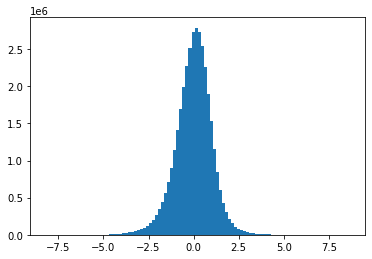

In [12]:
plt.hist(sel_df["normxpehh"], bins=100)
plt.show()

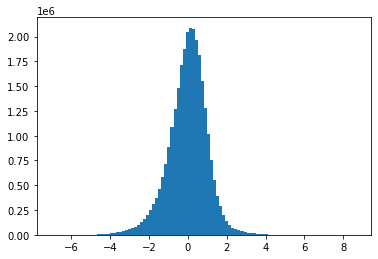

In [35]:
plt.hist(sel_df["normxpehh"], bins=100)
plt.show()

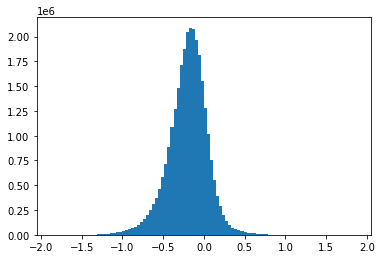

In [115]:
plt.hist(sel_df["xpehh"], bins=100)
plt.show()

In [112]:
sel_df
sel_df.sort_values(by='xpehh', ascending=False)

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh
2793910,NC_067199.1,28684878,NC_067199.1:28684878,28684900.0,0.006098,1981.820,0.279661,26.9185,1.86701
2793908,NC_067199.1,28684869,NC_067199.1:28684869,28684900.0,0.006098,1975.530,0.228814,28.5088,1.84071
2793896,NC_067199.1,28684816,NC_067199.1:28684816,28684800.0,0.006098,2870.630,0.440678,51.7572,1.74401
2793893,NC_067199.1,28684798,NC_067199.1:28684798,28684800.0,0.000000,2869.950,0.169492,52.4795,1.73788
2793911,NC_067199.1,28684880,NC_067199.1:28684880,28684900.0,0.000000,1983.090,0.084746,38.5301,1.71154
...,...,...,...,...,...,...,...,...,...
908581,NC_067200.1,9659379,NC_067200.1:9659379,9659380.0,0.018293,217.570,0.000000,14791.5000,-1.83241
908579,NC_067200.1,9659361,NC_067200.1:9659361,9659360.0,0.121951,209.224,0.000000,14791.5000,-1.84940
908582,NC_067200.1,9659381,NC_067200.1:9659381,9659380.0,0.920732,205.420,0.991525,14767.1000,-1.85665
908578,NC_067200.1,9659355,NC_067200.1:9659355,9659360.0,0.707317,203.280,0.000000,14791.5000,-1.86192


In [36]:
sel_df.sort_values(by=['chr', "pos"])
sel_df

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,normxpehh,crit
0,NC_067196.1,147067,NC_067196.1:147067,147067.0,0.158537,3849.020,0.381356,2542.010,0.180172,1.58557,0
1,NC_067196.1,147068,NC_067196.1:147068,147068.0,0.048780,3270.680,0.186441,1366.650,0.378980,2.42020,1
2,NC_067196.1,147069,NC_067196.1:147069,147069.0,0.024390,3022.890,0.000000,1374.130,0.342395,2.26661,1
3,NC_067196.1,147070,NC_067196.1:147070,147070.0,0.000000,3023.680,0.000000,1374.130,0.342510,2.26709,1
4,NC_067196.1,147072,NC_067196.1:147072,147072.0,0.018293,3023.510,0.000000,1374.130,0.342485,2.26699,1
...,...,...,...,...,...,...,...,...,...,...,...
2117383,NC_067202.1,19477723,NC_067202.1:19477723,19477700.0,0.000000,398.509,0.000000,270.019,0.169044,1.53885,0
2117384,NC_067202.1,19477730,NC_067202.1:19477730,19477700.0,0.036585,396.811,0.000000,270.019,0.167189,1.53106,0
2117385,NC_067202.1,19477740,NC_067202.1:19477740,19477700.0,0.000000,409.008,0.000000,270.019,0.180337,1.58626,0
2117386,NC_067202.1,19477770,NC_067202.1:19477770,19477800.0,0.390244,333.042,0.245763,207.029,0.206467,1.69596,0


In [ ]:
pos_df = pd.read_csv(f"{proj_dir}/results/fig_plotting_info/plotting_info.csv", sep=",") #generated in prep_figs_info.ipynb

offsets=dict(zip(pos_df["contig"], pos_df["x_start"].astype(int)))
colors=dict(zip(pos_df["contig"], pos_df["color"].astype(str)))

x=[]
c=[]

for index, row in tqdm(sel_df.iterrows()):
    snv_id=row["id"]
    chrom = row["chr"]
    
    offset=offsets[chrom]
    color = colors[chrom]
    
    x.append(row["pos"] + offset)
    c.append(color)
    
sel_df["genomic_position"] = x
sel_df["color"] = c

4181856it [02:45, 31403.51it/s]

In [ ]:
sel_df.to_csv("sel_df_norm.csv", sep=",", header=True, index=False)

In [13]:
z_scores = stats.zscore(sel_df["xpehh"])
#sel_df["norm_z_scores"] = z_scores


In [14]:
p_values = stats.norm.sf(np.abs(sel_df["normxpehh"])) * 2  # Two-tailed p-values
sel_df["norm_p_value"] = p_values

sel_df

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,normxpehh,crit,norm_p_value
0,NC_067195.1,16981,NC_067195.1:16981,16981.0,0.000000,526.758,0.042373,1417.040,-0.429771,-1.81653,0,0.069289
1,NC_067195.1,16982,NC_067195.1:16982,16982.0,0.012195,514.763,0.000000,1420.990,-0.440983,-1.87203,0,0.061202
2,NC_067195.1,16993,NC_067195.1:16993,16993.0,0.036585,484.027,0.000000,1420.990,-0.467720,-2.00436,1,0.045032
3,NC_067195.1,16994,NC_067195.1:16994,16994.0,0.128049,471.285,0.000000,1420.990,-0.479306,-2.06171,1,0.039235
4,NC_067195.1,16995,NC_067195.1:16995,16995.0,0.006098,474.874,0.000000,1420.990,-0.476012,-2.04540,1,0.040815
...,...,...,...,...,...,...,...,...,...,...,...,...
2117383,NC_067202.1,19477723,NC_067202.1:19477723,19477700.0,0.000000,398.509,0.000000,270.019,0.169044,1.53885,0,0.123841
2117384,NC_067202.1,19477730,NC_067202.1:19477730,19477700.0,0.036585,396.811,0.000000,270.019,0.167189,1.53106,0,0.125755
2117385,NC_067202.1,19477740,NC_067202.1:19477740,19477700.0,0.000000,409.008,0.000000,270.019,0.180337,1.58626,0,0.112680
2117386,NC_067202.1,19477770,NC_067202.1:19477770,19477800.0,0.390244,333.042,0.245763,207.029,0.206467,1.69596,0,0.089893


In [ ]:
sel_df.to_csv("sel_df_norm.csv", sep=",", header=True, index=False)

In [15]:
# Bonferroni correction
_, p_values_bonferroni, _, _ = smm.multipletests(sel_df["norm_p_value"], method='bonferroni')
sel_df["p_value_bonferroni"] = p_values_bonferroni

# Benjamini-Hochberg correction (False Discovery Rate)
_, fdr, _, _ = smm.multipletests(sel_df["norm_p_value"], method='fdr_bh')
sel_df["fdr"] = fdr

In [ ]:
sel_df.to_csv("sel_df_norm.csv", sep=",", header=True, index=False)

In [8]:
sel_df=pd.read_csv("sel_df_norm.csv", sep=",")
sel_df

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,normxpehh,crit,genomic_position,color,norm_p_value,p_value_bonferroni,fdr,nw_intro
0,NC_067196.1,147067,NC_067196.1:147067,147067.0,0.158537,3849.020,0.381356,2542.010,0.180172,1.58557,0,147067,#078d70,0.112837,1.0,0.999997,0.823171
1,NC_067196.1,147068,NC_067196.1:147068,147068.0,0.048780,3270.680,0.186441,1366.650,0.378980,2.42020,1,147068,#078d70,0.015512,1.0,0.562670,0.823171
2,NC_067196.1,147069,NC_067196.1:147069,147069.0,0.024390,3022.890,0.000000,1374.130,0.342395,2.26661,1,147069,#078d70,0.023414,1.0,0.679088,0.823171
3,NC_067196.1,147070,NC_067196.1:147070,147070.0,0.000000,3023.680,0.000000,1374.130,0.342510,2.26709,1,147070,#078d70,0.023385,1.0,0.678738,0.823171
4,NC_067196.1,147072,NC_067196.1:147072,147072.0,0.018293,3023.510,0.000000,1374.130,0.342485,2.26699,1,147072,#078d70,0.023391,1.0,0.678825,0.823171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28585158,NC_067202.1,19477723,NC_067202.1:19477723,19477700.0,0.000000,398.509,0.000000,270.019,0.169044,1.53885,0,317910191,#078d70,0.123841,1.0,0.999997,0.018293
28585159,NC_067202.1,19477730,NC_067202.1:19477730,19477700.0,0.036585,396.811,0.000000,270.019,0.167189,1.53106,0,317910198,#078d70,0.125755,1.0,0.999997,0.018293
28585160,NC_067202.1,19477740,NC_067202.1:19477740,19477700.0,0.000000,409.008,0.000000,270.019,0.180337,1.58626,0,317910208,#078d70,0.112680,1.0,0.999997,0.018293
28585161,NC_067202.1,19477770,NC_067202.1:19477770,19477800.0,0.390244,333.042,0.245763,207.029,0.206467,1.69596,0,317910238,#078d70,0.089893,1.0,0.999997,0.018293


In [16]:
alpha = 0.01
sig_bonf = sel_df[sel_df["p_value_bonferroni"] < alpha]
sig_fdr = sel_df[sel_df["fdr"] < alpha]

In [18]:
sig_bonf["chr"].value_counts()

NC_067195.1    195
NC_067199.1    167
NC_067200.1    110
NC_067196.1     11
NC_067198.1      3
NC_067197.1      2
NC_067202.1      2
Name: chr, dtype: int64

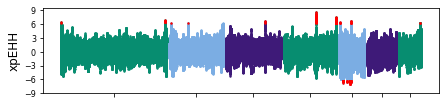

In [77]:
#plot the results
#fig, ax = plt.subplots()

# Create the Manhattan plot figure and axis
cm = 1/2.54
fig, ax = plt.subplots(figsize=(16*cm, 4*cm), facecolor="white")

# Define three shades of grey
shades_of_grey = ['#808080', '#A0A0A0', '#C0C0C0']
mlm_colors= ["#078d70", "#7bade3", "#3e1a78"]

# Create the colormap
custom_cmap = ListedColormap(mlm_colors)

#plot position of the invadolysin locus
#plt.axvline(x=invad_loc, ymin=-3, ymax=3)

# Iterate through the groups of chromosomes and plot each group with a different color

for i, (chrom, group) in enumerate(sel_df.groupby("chr")):
    color = custom_cmap(i % custom_cmap.N)  # Get a color from the colormap
    ax.scatter(group["genomic_position"], group["normxpehh"], s=2, alpha=1, color=color, label=f'{chrom}', zorder=2)

# # Plot the significant data points (Bonferroni corrected) in red
ax.scatter(sig_bonf["genomic_position"], sig_bonf["normxpehh"], s=2, alpha=1, color='red', label='Sig.', zorder=3)

# # Set the x-axis and y-axis labels
#ax.set_xlabel("Genomic Position", fontsize=12)
ax.set_ylabel("xpEHH", fontsize=12)
ax.tick_params(axis='y', labelsize=8)

x_ticks =list(pos_df["mid_tick"].astype(int)[0:7])
x_labels =list(pos_df["contig"].astype(str)[0:7])
y_ticks = list(range(-9, 10, 3))
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels([])
                     
#ax.axhline(y=sig_bonf["xpehh"][sig_bonf["xpehh"]>0].min(), color='black', linestyle="dashed", linewidth=0.5)
#ax.axhline(y=sig_bonf["xpehh"][sig_bonf["xpehh"]<0].max(), color='black', linestyle="dashed", linewidth=0.5)

#plot invadolysin line
#ax.axvline(x=invad_loc_x, color='tomato', linestyle="solid", linewidth=1, zorder=1)


# Add the legend outside the plot in the upper right corner
#ax.legend(markerscale=3, fontsize=12, loc='upper left')

# Adjust the layout to fit the plot in the figure
plt.tight_layout()


# Save the plot as an SVG file
#fig.savefig('nw_vs_se_xpehh_norm.svg', format='svg')

# Save the plot as a 300 dpi PNG file
#fig.savefig('nw_vs_se_xpehh_norm.png', format='png', dpi=300, bbox_inches='tight')



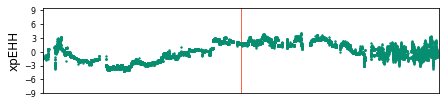

In [131]:
#plot the results
#fig, ax = plt.subplots()

# Create the Manhattan plot figure and axis
cm = 1/2.54
fig, ax = plt.subplots(figsize=(16*cm, 4*cm), facecolor="white")

# Define three shades of grey
shades_of_grey = ['#808080', '#A0A0A0', '#C0C0C0']
mlm_colors= ["#078d70", "#7bade3", "#3e1a78"]

# Create the colormap
custom_cmap = ListedColormap(mlm_colors)

#plot position of the invadolysin locus
#plt.axvline(x=invad_loc, ymin=-3, ymax=3)

# Iterate through the groups of chromosomes and plot each group with a different color

for i, (chrom, group) in enumerate(sel_df.groupby("chr")):
    color = custom_cmap(i % custom_cmap.N)  # Get a color from the colormap
    ax.scatter(group["genomic_position"], group["normxpehh"], s=2, alpha=1, color=color, label=f'{chrom}', zorder=2)

# # Plot the significant data points (Bonferroni corrected) in red
ax.scatter(sig_bonf["genomic_position"], sig_bonf["normxpehh"], s=2, alpha=1, color='red', label='Sig.', zorder=3)

# # Set the x-axis and y-axis labels
#ax.set_xlabel("Genomic Position", fontsize=12)
ax.set_ylabel("xpEHH", fontsize=12)
ax.tick_params(axis='y', labelsize=8)

x_ticks =list(pos_df["mid_tick"].astype(int)[0:7])
x_labels =list(pos_df["contig"].astype(str)[0:7])
y_ticks = list(range(-9, 10, 3))
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels([])
                     
#ax.axhline(y=sig_bonf["xpehh"][sig_bonf["xpehh"]>0].min(), color='black', linestyle="dashed", linewidth=0.5)
#ax.axhline(y=sig_bonf["xpehh"][sig_bonf["xpehh"]<0].max(), color='black', linestyle="dashed", linewidth=0.5)

#plot invadolysin line
invad_loc_x = offsets["NC_067199.1"] + ((28_467_137+28_495_140)/2)
invad_loc_x
ax.axvline(x=invad_loc_x, color='tomato', linestyle="solid", linewidth=1, zorder=1)
plt.xlim([invad_loc_x-100_000, invad_loc_x + 100_000])

# Add the legend outside the plot in the upper right corner
#ax.legend(markerscale=3, fontsize=12, loc='upper left')

# Adjust the layout to fit the plot in the figure
plt.tight_layout()


# Save the plot as an SVG file
#fig.savefig('nw_vs_se_xpehh_norm.svg', format='svg')

# Save the plot as a 300 dpi PNG file
#fig.savefig('zoom_nw_vs_se_xpehh_norm.png', format='png', dpi=300, bbox_inches='tight')



In [6]:
sel_df=pd.read_csv("sel_df_norm.csv", sep=",")

# Compare XPEHH values to the percent of Sb introgression in NW Africa

read in the introgression data from the `09-ancestry.ipynb` notebook

In [93]:
i_df = pd.read_csv(f"{proj_dir}/results/rfmix/rfmix_perc_bovis_genome.csv", sep=",")
i_df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,n_sb,n_sh_nw,n_sh_se,perc_sb,perc_sh_nw,perc_sh_se,x_start,x_end,color
0,NC_067195.1,14416,75442,0.05,0.26,582,0,156,42,1.0,0.048780,0.0,320428073,320489099,#7bade3
1,NC_067195.1,75442,106309,0.26,0.37,335,0,155,42,1.0,0.054878,0.0,320489099,320519966,#7bade3
2,NC_067195.1,106309,146168,0.37,0.51,465,0,154,42,1.0,0.060976,0.0,320519966,320559825,#7bade3
3,NC_067195.1,146168,156662,0.51,0.55,580,0,154,42,1.0,0.060976,0.0,320559825,320570319,#7bade3
4,NC_067195.1,156662,164518,0.55,0.57,885,0,155,42,1.0,0.054878,0.0,320570319,320578175,#7bade3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067202.1,19335566,19381118,67.37,67.53,4950,0,159,42,1.0,0.030488,0.0,317768034,317813586,#078d70
39473,NC_067202.1,19381118,19401743,67.53,67.60,2335,0,158,42,1.0,0.036585,0.0,317813586,317834211,#078d70
39474,NC_067202.1,19401743,19427939,67.60,67.69,2290,0,159,42,1.0,0.030488,0.0,317834211,317860407,#078d70
39475,NC_067202.1,19427939,19464116,67.69,67.82,1825,0,160,42,1.0,0.024390,0.0,317860407,317896584,#078d70


add the introgression data to an interval tree

In [97]:
trees={}

# Iterate over the DataFrame rows
for index, row in tqdm(i_df.iterrows()):
    # Get the chromosome name
    chrom      = row["chrom"]
    start      = row["s_pos"]
    stop       = row["e_pos"]
    perc_intro = row["perc_sh_nw"]
    
    # Initialize the interval tree for this chromosome if it doesn't exist yet
    if chrom not in trees:
        trees[chrom] = IntervalTree()
    
    # Add the interval to the tree
    trees[chrom][start:stop] = perc_intro

39477it [00:02, 16419.52it/s]


now cycle through the table containing the xpehh data, look up that position in the interval tree and add it to the dataframe

In [101]:
sel_df["nw_intro"] = None
sel_df

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,normxpehh,crit,genomic_position,color,norm_p_value,p_value_bonferroni,fdr,nw_intro
0,NC_067196.1,147067,NC_067196.1:147067,147067.0,0.158537,3849.020,0.381356,2542.010,0.180172,1.58557,0,147067,#078d70,0.112837,1.0,0.999997,None
1,NC_067196.1,147068,NC_067196.1:147068,147068.0,0.048780,3270.680,0.186441,1366.650,0.378980,2.42020,1,147068,#078d70,0.015512,1.0,0.562670,None
2,NC_067196.1,147069,NC_067196.1:147069,147069.0,0.024390,3022.890,0.000000,1374.130,0.342395,2.26661,1,147069,#078d70,0.023414,1.0,0.679088,None
3,NC_067196.1,147070,NC_067196.1:147070,147070.0,0.000000,3023.680,0.000000,1374.130,0.342510,2.26709,1,147070,#078d70,0.023385,1.0,0.678738,None
4,NC_067196.1,147072,NC_067196.1:147072,147072.0,0.018293,3023.510,0.000000,1374.130,0.342485,2.26699,1,147072,#078d70,0.023391,1.0,0.678825,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28585158,NC_067202.1,19477723,NC_067202.1:19477723,19477700.0,0.000000,398.509,0.000000,270.019,0.169044,1.53885,0,317910191,#078d70,0.123841,1.0,0.999997,None
28585159,NC_067202.1,19477730,NC_067202.1:19477730,19477700.0,0.036585,396.811,0.000000,270.019,0.167189,1.53106,0,317910198,#078d70,0.125755,1.0,0.999997,None
28585160,NC_067202.1,19477740,NC_067202.1:19477740,19477700.0,0.000000,409.008,0.000000,270.019,0.180337,1.58626,0,317910208,#078d70,0.112680,1.0,0.999997,None
28585161,NC_067202.1,19477770,NC_067202.1:19477770,19477800.0,0.390244,333.042,0.245763,207.029,0.206467,1.69596,0,317910238,#078d70,0.089893,1.0,0.999997,None


In [103]:
for index,row in sel_df.iterrows():
    chrom=row["chr"]
    pos=row["pos"]
    intro=list(trees[chrom][pos])[0].data
    sel_df.loc[index, "nw_intro"] = intro

In [104]:
sel_df.to_csv("sel_df_norm.csv", sep=",", header=True, index=False)

In [8]:
sel_df = pd.read_csv("sel_df_norm.csv", sep=",", header=0)
sel_df

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,normxpehh,crit,genomic_position,color,norm_p_value,p_value_bonferroni,fdr,nw_intro
0,NC_067196.1,147067,NC_067196.1:147067,147067.0,0.158537,3849.020,0.381356,2542.010,0.180172,1.58557,0,147067,#078d70,0.112837,1.0,0.999997,0.823171
1,NC_067196.1,147068,NC_067196.1:147068,147068.0,0.048780,3270.680,0.186441,1366.650,0.378980,2.42020,1,147068,#078d70,0.015512,1.0,0.562670,0.823171
2,NC_067196.1,147069,NC_067196.1:147069,147069.0,0.024390,3022.890,0.000000,1374.130,0.342395,2.26661,1,147069,#078d70,0.023414,1.0,0.679088,0.823171
3,NC_067196.1,147070,NC_067196.1:147070,147070.0,0.000000,3023.680,0.000000,1374.130,0.342510,2.26709,1,147070,#078d70,0.023385,1.0,0.678738,0.823171
4,NC_067196.1,147072,NC_067196.1:147072,147072.0,0.018293,3023.510,0.000000,1374.130,0.342485,2.26699,1,147072,#078d70,0.023391,1.0,0.678825,0.823171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28585158,NC_067202.1,19477723,NC_067202.1:19477723,19477700.0,0.000000,398.509,0.000000,270.019,0.169044,1.53885,0,317910191,#078d70,0.123841,1.0,0.999997,0.018293
28585159,NC_067202.1,19477730,NC_067202.1:19477730,19477700.0,0.036585,396.811,0.000000,270.019,0.167189,1.53106,0,317910198,#078d70,0.125755,1.0,0.999997,0.018293
28585160,NC_067202.1,19477740,NC_067202.1:19477740,19477700.0,0.000000,409.008,0.000000,270.019,0.180337,1.58626,0,317910208,#078d70,0.112680,1.0,0.999997,0.018293
28585161,NC_067202.1,19477770,NC_067202.1:19477770,19477800.0,0.390244,333.042,0.245763,207.029,0.206467,1.69596,0,317910238,#078d70,0.089893,1.0,0.999997,0.018293


In [105]:
sel_df["nw_intro"].min()

0.0

In [ ]:
sig_bonf

plot the results as a scatter plot

In [9]:
alpha=0.05

se_df = sel_df.loc[(sel_df["p_value_bonferroni"] <= alpha) &
                (sel_df["fdr"] <= alpha) & 
                (sel_df["normxpehh"] < 0) ]

nw_df = sel_df.loc[(sel_df["p_value_bonferroni"] <= alpha) &
                (sel_df["fdr"] <= alpha) & 
                (sel_df["normxpehh"] > 0) ]

nw_df

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,normxpehh,crit,genomic_position,color,norm_p_value,p_value_bonferroni,fdr,nw_intro
3402,NC_067196.1,335206,NC_067196.1:335206,335206.0,0.054878,1495.840,0.211864,68.8998,1.33667,6.44075,1,335206,#078d70,1.188846e-10,0.003398,0.000020,0.829268
3403,NC_067196.1,335208,NC_067196.1:335208,335208.0,0.060976,1497.470,0.372881,71.6993,1.31984,6.37009,1,335208,#078d70,1.889173e-10,0.005400,0.000024,0.829268
3404,NC_067196.1,335212,NC_067196.1:335212,335212.0,0.000000,1498.450,0.000000,81.5155,1.26440,6.13734,1,335212,#078d70,8.391466e-10,0.023987,0.000043,0.829268
3405,NC_067196.1,335213,NC_067196.1:335213,335213.0,0.060976,1489.090,0.000000,81.5155,1.26168,6.12593,1,335213,#078d70,9.015544e-10,0.025771,0.000045,0.829268
3406,NC_067196.1,335215,NC_067196.1:335215,335215.0,0.060976,1489.090,0.000000,81.5155,1.26168,6.12593,1,335215,#078d70,9.015544e-10,0.025771,0.000045,0.829268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28509637,NC_067202.1,18613640,NC_067202.1:18613640,18613600.0,0.000000,2353.650,0.084746,132.2120,1.25047,6.07886,1,317046108,#078d70,1.210400e-09,0.034599,0.000052,0.073171
28509645,NC_067202.1,18613669,NC_067202.1:18613669,18613700.0,0.103659,2162.860,0.508475,125.1010,1.23777,6.02555,1,317046137,#078d70,1.685355e-09,0.048176,0.000063,0.073171
28509695,NC_067202.1,18614090,NC_067202.1:18614090,18614100.0,0.823171,1839.770,0.483051,106.3850,1.23788,6.02601,1,317046558,#078d70,1.680568e-09,0.048039,0.000063,0.073171
28523281,NC_067202.1,18770708,NC_067202.1:18770708,18770700.0,0.012195,1196.570,0.440678,60.3998,1.29690,6.27379,1,317203176,#078d70,3.523637e-10,0.010072,0.000030,0.042683


In [10]:
se_df

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,normxpehh,crit,genomic_position,color,norm_p_value,p_value_bonferroni,fdr,nw_intro
21960965,NC_067200.1,2751101,NC_067200.1:2751101,2751100.0,0.103659,451.304,0.110169,19855.50,-1.64341,-6.07014,1,248525378,#7bade3,1.277988e-09,0.036531,0.000054,0.402439
21960966,NC_067200.1,2751104,NC_067200.1:2751104,2751100.0,0.060976,465.948,0.000000,20932.80,-1.65249,-6.10826,1,248525381,#7bade3,1.007232e-09,0.028792,0.000048,0.402439
21960967,NC_067200.1,2751115,NC_067200.1:2751115,2751120.0,0.018293,477.561,0.000000,20932.80,-1.64180,-6.06338,1,248525392,#7bade3,1.332902e-09,0.038101,0.000055,0.402439
21960968,NC_067200.1,2751117,NC_067200.1:2751117,2751120.0,0.000000,480.510,0.000000,20932.80,-1.63912,-6.05213,1,248525394,#7bade3,1.429430e-09,0.040861,0.000057,0.402439
21960969,NC_067200.1,2751120,NC_067200.1:2751120,2751120.0,0.000000,480.510,0.000000,20932.80,-1.63912,-6.05213,1,248525397,#7bade3,1.429430e-09,0.040861,0.000057,0.402439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22725000,NC_067200.1,10269509,NC_067200.1:10269509,10269500.0,0.006098,139.327,0.000000,6263.05,-1.65275,-6.10935,1,256043786,#7bade3,1.000377e-09,0.028596,0.000047,0.597561
22725001,NC_067200.1,10269513,NC_067200.1:10269513,10269500.0,0.201220,138.294,0.000000,6263.05,-1.65598,-6.12291,1,256043790,#7bade3,9.188160e-10,0.026265,0.000045,0.597561
22725002,NC_067200.1,10269519,NC_067200.1:10269519,10269500.0,0.176829,138.241,0.000000,6263.05,-1.65615,-6.12363,1,256043796,#7bade3,9.146716e-10,0.026146,0.000045,0.597561
22725003,NC_067200.1,10269523,NC_067200.1:10269523,10269500.0,0.292683,129.462,0.000000,6263.05,-1.68464,-6.24323,1,256043800,#7bade3,4.286259e-10,0.012252,0.000030,0.597561


In [63]:
sel_df.loc[sel_df["pos"].astype(int) == 28983994]

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,normxpehh,crit,genomic_position,color,norm_p_value,p_value_bonferroni,fdr,nw_intro
19934579,NC_067199.1,28983994,NC_067199.1:28983994,28984000.0,0.012195,213.652,1.0,129.88,0.216164,1.73667,0,225486535,#078d70,0.082445,1.0,0.999997,0.981707


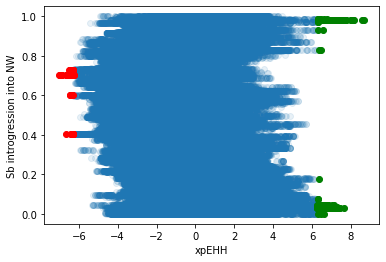

In [123]:
plt.scatter(sel_df["normxpehh"], sel_df["nw_intro"], alpha=0.1, zorder=1)
plt.scatter(se_df["normxpehh"], se_df["nw_intro"], alpha=1, c="red", zorder=2)
plt.scatter(nw_df["normxpehh"], nw_df["nw_intro"], alpha=1, c="green", zorder=2)

plt.xlabel("xpEHH")
plt.ylabel("Sb introgression into NW")
plt.show()

# Save the plot as an SVG file
#plt.savefig('introgression_vs_xpehh.svg', format='svg')

# Save the plot as a 300 dpi PNG file
#plt.savefig('introgression_vs_xpehh.png', dpi=300, format='png')

In [113]:
nw_df["nw_intro"].median()

0.0365853658536585

In [112]:
se_df["nw_intro"].median()

0.7012195121951219

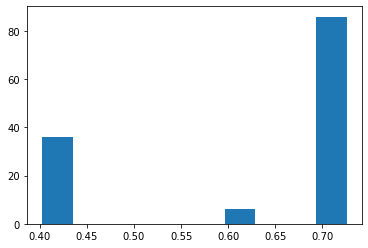

In [18]:
plt.hist(neg_df["nw_intro"], bins=10)
plt.show()

In [111]:
sel_df["nw_intro"].median()

0.0304878048780488

In [ ]:
sel_df["nw_intro"].median()

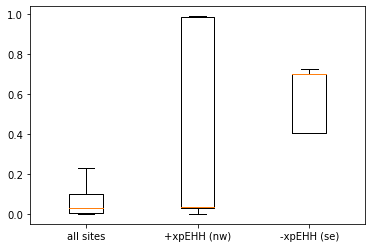

In [132]:
plt.boxplot([sel_df["nw_intro"], nw_df["nw_intro"], se_df["nw_intro"]], showfliers=False)
plt.xticks([1, 2, 3], ['all sites', '+xpEHH (nw)', '-xpEHH (se)'])
plt.show()

In [172]:
alpha = 0.05
sig_bonf = sel_df[sel_df["p_value_bonferroni"] < alpha]

df = sig_bonf.sort_values(by=['chr', 'pos']).reset_index(drop=True)

def identify_group(s):
    return (s - s.shift()).gt(1000000).cumsum()

# Groupby chr and the identified groups to get the range, mean xpehh, and count
grouped_df = df.groupby(['chr', df.groupby('chr')['pos'].apply(identify_group)]).agg(
    start_pos=('pos', 'first'),
    end_pos=('pos', 'last'),
    med_xpehh=('normxpehh', 'median'),  # Calculate mean xpehh for each group
    count=('pos', 'size')  # Count the number of items in each group
).reset_index().drop(columns='pos')  # Drop the helper column

grouped_df["size"] = grouped_df["end_pos"] - grouped_df["start_pos"] +1
grouped_df.to_csv("xpehh_sig_groups.csv", sep=",", header=True, index=False)
bed = grouped_df[["chr", "start_pos", "end_pos"]]
bed.to_csv("xpehh_sig_groups.bed", sep="\t", header=False, index=False)
grouped_df

,chr,start_pos,end_pos,med_xpehh,count,size
0,NC_067196.1,335206,335217,6.191205,6,12
1,NC_067196.1,92138959,92200695,6.100900,35,61737
2,NC_067197.1,1449094,1449133,6.096160,4,40
3,NC_067197.1,16497345,16497347,6.326160,2,3
4,NC_067197.1,46292383,47002310,6.089045,10,709928
5,NC_067198.1,34371482,34372131,6.143600,21,650
6,NC_067199.1,28684446,28684893,6.788500,62,448
7,NC_067199.1,46492133,46551456,6.286760,233,59324
8,NC_067200.1,503501,703282,6.134570,17,199782
9,NC_067200.1,2751101,2751780,-6.243230,116,680


In [174]:
len_df = pd.read_csv(f"{proj_dir}/data/GCF_000699445.3_UoM_Shae.V3_genomic.fna.fai", sep="\t", header=None)
len_df.columns=["contig", "length", "offset", "linebases", "linewidth"]


grouped_df["chr_len"]=""

lens = len_df.set_index('contig')['length'].to_dict()

grouped_df['chr_len'] = grouped_df['chr'].map(lens)
                                             
grouped_df                                           

,chr,start_pos,end_pos,med_xpehh,count,size,chr_len
0,NC_067196.1,335206,335217,6.191205,6,12,93306550
1,NC_067196.1,92138959,92200695,6.100900,35,61737,93306550
2,NC_067197.1,1449094,1449133,6.096160,4,40,47367863
3,NC_067197.1,16497345,16497347,6.326160,2,3,47367863
4,NC_067197.1,46292383,47002310,6.089045,10,709928,47367863
5,NC_067198.1,34371482,34372131,6.143600,21,650,48328128
6,NC_067199.1,28684446,28684893,6.788500,62,448,46771736
7,NC_067199.1,46492133,46551456,6.286760,233,59324,46771736
8,NC_067200.1,503501,703282,6.134570,17,199782,22148653
9,NC_067200.1,2751101,2751780,-6.243230,116,680,22148653


In [175]:
min_values = grouped_df.apply(lambda row: min(row["chr_len"] - row["end_pos"], row["start_pos"]), axis=1)
grouped_df["bp_to_chr_end"] = min_values
grouped_df["per_to_chr_end"] = (grouped_df["bp_to_chr_end"] / grouped_df["chr_len"])*100
grouped_df

,chr,start_pos,end_pos,med_xpehh,count,size,chr_len,bp_to_chr_end,per_to_chr_end
0,NC_067196.1,335206,335217,6.191205,6,12,93306550,335206,0.359252
1,NC_067196.1,92138959,92200695,6.100900,35,61737,93306550,1105855,1.185185
2,NC_067197.1,1449094,1449133,6.096160,4,40,47367863,1449094,3.059234
3,NC_067197.1,16497345,16497347,6.326160,2,3,47367863,16497345,34.828139
4,NC_067197.1,46292383,47002310,6.089045,10,709928,47367863,365553,0.771732
5,NC_067198.1,34371482,34372131,6.143600,21,650,48328128,13955997,28.877587
6,NC_067199.1,28684446,28684893,6.788500,62,448,46771736,18086843,38.670455
7,NC_067199.1,46492133,46551456,6.286760,233,59324,46771736,220280,0.470968
8,NC_067200.1,503501,703282,6.134570,17,199782,22148653,503501,2.273280
9,NC_067200.1,2751101,2751780,-6.243230,116,680,22148653,2751101,12.421076


In [176]:
target_df = grouped_df.loc[ (grouped_df["per_to_chr_end"] > 5) & (grouped_df["count"] > 10) ].reset_index(drop=True)
target_df

,chr,start_pos,end_pos,med_xpehh,count,size,chr_len,bp_to_chr_end,per_to_chr_end
0,NC_067198.1,34371482,34372131,6.14360,21,650,48328128,13955997,28.877587
1,NC_067199.1,28684446,28684893,6.78850,62,448,46771736,18086843,38.670455
2,NC_067200.1,2751101,2751780,-6.24323,116,680,22148653,2751101,12.421076
3,NC_067200.1,6627231,6627310,-6.25973,13,80,22148653,6627231,29.921598
4,NC_067200.1,9584831,10269524,-6.21156,234,684694,22148653,9584831,43.275006


In [166]:
target_df.to_csv("target_xpehh_sig_groups.csv", sep=",", header=True, index=False)
target_bed = target_df[["chr", "start_pos", "end_pos"]]
target_bed.to_csv("target_xpehh_sig_groups.bed", sep="\t", header=False, index=False)

# IMPACT ON GENES

In [ ]:
#after running 13-snpeff.ipynb

In [171]:
sig_bonf["id"].to_csv("sig_xpehh_snvs.list", header=False, index=False)

In [ ]:
#vcftools 

In [130]:
loci_bed = pybedtools.BedTool("xpehh_sig_groups.bed")


NameError: name 'pybedtools' is not defined

In [49]:
gff_file = f"{proj_dir}/data/GCF_000699445.3_UoM_Shae.V3_genomic.gff"

gffutils.create_db(gff_file, dbfn='gff.db', force=True, keep_order=True, merge_strategy="create_unique", sort_attribute_values=True)
gff_db = gffutils.FeatureDB('gff.db', keep_order=True)

In [50]:
with open("genes_selection_peaks.csv", 'w') as out_f:
    outline = "gene,chrom,start,stop,locus\n"
    out_f.write(outline)
    
    for loci in loci_bed:
        genes = gff_db.region(region=(loci.chrom, loci.start, loci.stop), completely_within=False, featuretype=['gene'])
        for gene in genes:
            outline="{},{},{},{},{}:{}-{}".format(gene.id, gene.chrom, gene.start, gene.stop, loci.chrom, loci.start, loci.stop)
            out_f.write("{}\n".format(outline))

In [9]:
genes_df=pd.read_csv("genes_in_sh_loci_with_95p_sb.csv")
genes_df

,gene,chrom,start,stop,locus
0,gene-MS3_00007799,NC_067199.1,28330274,28349965,NC_067199.1:28316229-28343298
1,gene-MS3_00007799,NC_067199.1,28330274,28349965,NC_067199.1:28343298-28384274
2,gene-MS3_00007800,NC_067199.1,28351994,28368226,NC_067199.1:28343298-28384274
3,gene-MS3_00000454,NC_067199.1,28392842,28408678,NC_067199.1:28384274-28486462
4,gene-MS3_00007801,NC_067199.1,28420471,28433683,NC_067199.1:28384274-28486462
...,...,...,...,...,...
74,gene-MS3_00008927,NC_067200.1,1528357,1552456,NC_067200.1:1504382-1530996
75,gene-MS3_00008927,NC_067200.1,1528357,1552456,NC_067200.1:1530996-1570035
76,gene-MS3_00008928,NC_067200.1,1555623,1577345,NC_067200.1:1530996-1570035
77,gene-MS3_00008928,NC_067200.1,1555623,1577345,NC_067200.1:1570035-1576448


In [25]:
%%bash 

conda run -n bedtools --cwd . --live-stream bedtools merge -d 200000 -i high_sb_regions.bed >merged_high_sb_regions.bed

In [26]:
!cat merged_high_sb_regions.bed

NC_067199.1	28314439	29311552
NC_067200.1	217479	1576448
NC_067200.1	10047409	10177940


# pbs

In [16]:
Path("{}/pbs".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/pbs".format(results_dir))

In [ ]:
#get sites genotyped in margrebowiei
vcftools --vcf ../filter_genotypes/sorted_annotated_snps.vcf \
         --indv margrebowiei_zambia_ERR310940 \
         --recode \
         --recode-INFO-all \
         --out smarg


In [ ]:
cat smarg.recode.vcf | grep -v "#" | grep -v "\./\." | cut -f1,2 >smarg.sites

In [ ]:
vcftools --vcf ../filter_genotypes/sorted_annotated_snps.vcf \
         --pos smarg.sites \
         --recode \
         --recode-INFO-all \
         --out smarg_sites

In [17]:
#read in the vcf file
filtered_callset=allel.read_vcf('smarg_sites.recode.vcf')

In [18]:
#get relevant info
gt      = allel.GenotypeArray(filtered_callset['calldata/GT'])
chroms  = filtered_callset["variants/CHROM"]
samples = filtered_callset["samples"]
poss    = filtered_callset["variants/POS"]
var_ids = filtered_callset["variants/ID"]

uniq_chroms=np.unique(chroms)

In [19]:
#read in pca df since it has species ids and kmeans labels
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
pca_df["country"] = pca_df["country"].astype(str)

In [20]:
pca_df.loc[ (pca_df["kmeans_label"] == "sh_nw") & 
            (pca_df["project"] == "scan_africa")]

,sample_name,1,2,3,4,5,6,7,8,9,...,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species,kmeans_label
29,sbo_cdivoire_raviart_108,0.021400,-0.070582,-0.045198,0.206487,0.004450,0.012315,0.028276,-0.103222,-0.100459,...,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0,s_haematobium,sh_nw
30,sbo_cdivoire_raviart_109,0.020538,-0.076418,-0.046554,0.226617,-0.003926,-0.014860,-0.011537,-0.087275,-0.110759,...,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0,s_haematobium,sh_nw
31,sbo_niger_libore_154,0.025617,-0.079330,-0.013864,-0.055163,-0.001331,-0.003984,0.000089,-0.016355,0.055014,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
32,sbo_niger_libore_155,0.021715,-0.077734,-0.013288,-0.061101,0.008696,-0.056704,0.051375,-0.009732,0.050136,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
33,sbo_niger_libore_160,0.021868,-0.075221,-0.018740,-0.071181,-0.001439,-0.055054,0.051839,-0.075687,0.004744,...,na,snail,unk,scan_africa,genome,13.388050,2.199130,0,s_haematobium,sh_nw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,ssp_niger_libore_166,0.022455,-0.078463,-0.021334,-0.066131,0.005504,-0.046551,0.052623,-0.059921,0.043647,...,na,snail,unk,scan_africa,genome,13.388050,2.199130,0,s_haematobium,sh_nw
166,ssp_niger_libore_167,0.023576,-0.078099,-0.011150,-0.061000,0.017043,-0.045486,0.040388,-0.017674,0.024366,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
167,ssp_niger_libore_168,0.022321,-0.076938,-0.018901,-0.060000,0.006243,-0.004137,0.029055,-0.042276,0.080228,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
168,ssp_niger_libore_169,0.023969,-0.073719,-0.019718,-0.050199,0.016409,-0.015895,0.038597,-0.020768,0.037634,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw


### Species

In [21]:
#get species idxs
sp_idxs = {}
sp_acs  = {}

for sp in tqdm(["s_bovis", "s_haematobium"]):
    
    #find indecies for each sample from that species
    names = pca_df.loc[pca_df["pca_species"] ==  sp, "sample_name"]
    sp_idxs[sp]=np.in1d(samples, names).nonzero()[0]

    #get allele counts for each species
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:32<00:00, 16.49s/it]


In [22]:
#add outgroups
s_guineensis   = "guineensis_saotome_ERR119612"
s_intercalatum = "intercalatum_drcongo_ERR119613"
s_margrebowiei = "margrebowiei_zambia_ERR310940"
s_matthei      = "matthei_zambia_ERR103051"

outgroups=[s_guineensis, s_intercalatum, s_margrebowiei, s_matthei]


In [23]:
for sp in tqdm(outgroups):
    sp_idxs[sp] = [list(samples).index(sp)]
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.57s/it]


### Kmeans group

In [24]:
#get species idxs
k_pop_idxs = {}
k_pop_acs  = {}

for k in tqdm(pca_df["kmeans_label"].unique()):
    
    #find indecies for each sample per k population
    ks = pca_df.loc[pca_df["kmeans_label"] ==  k, "sample_name"]
    k_pop_idxs[k]=np.in1d(samples, ks).nonzero()[0]
    
    #get allele counts for k group
    k_pop_acs[k] = gt.count_alleles(subpop=k_pop_idxs[k])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:47<00:00,  6.73s/it]


In [25]:
major_acs={"sh_nw":          k_pop_acs["sh_nw"],
           "sh_se":          k_pop_acs["sh_se"],
           "sb":             k_pop_acs["sb"] ,
           "sh":             sp_acs["s_haematobium"],
           "s_guineensis":   sp_acs["guineensis_saotome_ERR119612"],
           "s_intercalatum": sp_acs["intercalatum_drcongo_ERR119613"],
           "s_margrebowiei": sp_acs["margrebowiei_zambia_ERR310940"],
           "s_matthei":      sp_acs["matthei_zambia_ERR103051"]  }

In [52]:
pbs_df=pd.DataFrame(columns=["chrom", "start", "stop", "pbs(nw:se,smg)", "pbs(se:nw,smg)"])

major_chroms=uniq_chroms[0:8]

for chrom in tqdm(major_chroms):
    chrom_pos = poss[chroms == chrom]

    nw=major_acs["sh_nw"][chroms == chrom]
    se=major_acs["sh_se"][chroms == chrom]
    smg=major_acs["s_margrebowiei"][chroms == chrom]
    
    try:
        
        pbs_nw = allel.pbs(nw, se, smg, 500, normed=True)
        pbs_se = allel.pbs(se, nw, smg, 500, normed=True)
   
        starts = list(chrom_pos[0::500])
        stops = list(chrom_pos[499::500])
        tmp_chrs = [chrom] * len(pbs_nw)
        

        #add info to a df
        chr_df=pd.DataFrame([tmp_chrs, starts[:-1], stops, pbs_nw, pbs_se]).T
        chr_df.columns=["chrom", "start", "stop", "pbs(nw:se,smg)", "pbs(se:nw,smg)"]

        pbs_df=pd.concat([pbs_df, chr_df])

    except:
        print(f"An exception occurred: {chrom}")
        break

   
    pbs_df["n_snps"] = 500

    #save df to a csv
    pbs_df=pbs_df.dropna().copy()
    #pbs_df.to_csv("pbs_nonphased.csv", index=False, sep=",")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:52<00:00,  6.61s/it]


In [53]:
pbs_df

,chrom,start,stop,"pbs(nw:se,smg)","pbs(se:nw,smg)",n_snps
0,NC_067195.1,15260,147117,0.012648,0.049742,500
1,NC_067195.1,147128,159894,-0.048256,0.061286,500
2,NC_067195.1,159897,164698,0.016087,0.005605,500
3,NC_067195.1,164700,171970,-0.062515,0.070771,500
4,NC_067195.1,171997,178611,-0.026144,0.055725,500
...,...,...,...,...,...,...
3141,NC_067202.1,19401761,19415439,0.003907,0.004642,500
3142,NC_067202.1,19415446,19423349,0.01008,0.003728,500
3143,NC_067202.1,19423366,19434444,0.000945,0.012795,500
3144,NC_067202.1,19434467,19464720,0.004292,0.019271,500


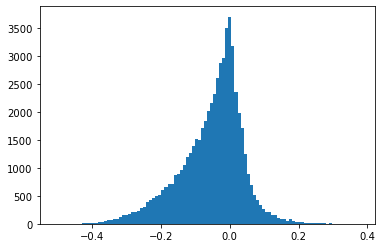

In [54]:
plt.hist(pbs_df["pbs(nw:se,smg)"], bins=100)
plt.show()

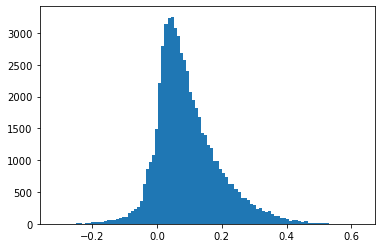

In [55]:
plt.hist(pbs_df["pbs(se:nw,smg)"], bins=100)
plt.show()

In [38]:
print(pbs_df['pbs'].dtype)
pbs_df['pbs'] = pd.to_numeric(pbs_df['pbs'], errors='coerce')
pbs_df = pbs_df.dropna(subset=['pbs'])
print(pbs_df['pbs'].dtype)
print(len(pbs_df))

object
float64
58615


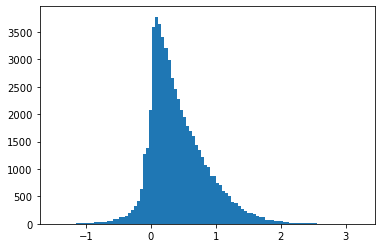

In [39]:
plt.hist(pbs_df["pbs"], bins=100)
plt.show()

In [40]:
pbs_df['z_scores'] = (pbs_df['pbs'] - pbs_df['pbs'].mean()) / pbs_df['pbs'].std()

#pbs_df.dropna()

pbs_df['p_values'] = stats.norm.sf(abs(pbs_df['z_scores'])) *2
alpha = 0.05
bonferroni_corrected_alpha = alpha / len(pbs_df)
pbs_df['significant'] = pbs_df['p_values'] < bonferroni_corrected_alpha
pbs_df.to_csv("pbs_nonphased.csv", index=False, sep=",", header=True)

In [12]:
pbs_df=pd.read_csv("pbs_nonphased.csv", sep=",", header=0)
pbs_df

,chrom,start,stop,pbs,n_snps,z_scores,p_values,significant
0,NC_067195.1,15260,147117,0.144191,500,-0.629137,0.529259,False
1,NC_067195.1,147128,159894,0.172733,500,-0.564554,0.572377,False
2,NC_067195.1,159897,164698,0.017485,500,-0.915836,0.359753,False
3,NC_067195.1,164700,171970,0.240505,500,-0.411206,0.680922,False
4,NC_067195.1,171997,178611,0.166726,500,-0.578146,0.563166,False
...,...,...,...,...,...,...,...,...
58610,NC_067202.1,19401761,19415439,0.011994,500,-0.928260,0.353273,False
58611,NC_067202.1,19415446,19423349,0.010876,500,-0.930790,0.351962,False
58612,NC_067202.1,19423366,19434444,0.043930,500,-0.856000,0.391998,False
58613,NC_067202.1,19434467,19464720,0.032380,500,-0.882134,0.377705,False


In [ ]:
#NC_067199.1:28_467_137-28_495_140

In [14]:
pbs_df[pbs_df['significant']]

13

In [280]:
pbs_df['pbs'] = pd.to_numeric(pbs_df['pbs'], errors='coerce')



In [268]:
fst_12 = 0.9
fst_13 = 0.7
fst_23 = 0.1

t12 =-np.log(1-fst_12)
t13 =-np.log(1-fst_13)
t23 =-np.log(1-fst_23)

t12 =0.15
t13 =0.24
t23 =0.03

pbs=(t12 + t13 - t23)/2
pbs

0.18

# delta tajima's d

In [311]:
Path("{}/delta_td".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/delta_td".format(results_dir))

In [225]:
dtd_df=pd.DataFrame()

major_chroms=uniq_chroms[0:8]

for chrom in tqdm(major_chroms):
    chrom_pos = poss[chroms == chrom]

    aca=major_acs["sh_nw"][chroms == chrom]
    acb=major_acs["sh_se"][chroms == chrom]
    
    try:
        
        dtd = allel.moving_delta_tajima_d(aca, acb, 500)
                  
        starts = list(chrom_pos[0::500])
        stops = list(chrom_pos[499::500])
        tmp_chrs = [chrom] * len(dtd)
        

        #add info to a df
        chr_df=pd.DataFrame([tmp_chrs, starts, stops, dtd]).T
        chr_df.columns=["chrom", "start", "stop", "delta_td"]

        dtd_df=pd.concat([dtd_df, chr_df])

    except:
        print(f"An exception occurred: {chrom}")
        break

   
    dtd_df["n_snps"] = 500

    dtd_df=dtd_df.dropna().copy()

        
    #save df to a csv
    dtd_df.to_csv(f"delta_tajimas_d.csv", index=False, sep=",")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


In [323]:
dtd_df['delta_td'] = pd.to_numeric(dtd_df['delta_td'], errors='coerce')
dtd_df = dtd_df.dropna(subset=['delta_td'])


In [324]:
dtd_df

,chrom,start,stop,delta_td,n_snps,z_scores
0,NC_067196.1,124225,200412,1.188410,500,1.188399
1,NC_067196.1,200439,209973,1.585773,500,1.585759
2,NC_067196.1,209975,225782,-0.283021,500,-0.283019
3,NC_067196.1,225798,284020,0.109052,500,0.109051
4,NC_067196.1,284021,298131,0.127597,500,0.127596
...,...,...,...,...,...,...
4230,NC_067202.1,19457726,19462461,-0.676960,500,-0.676954
4231,NC_067202.1,19462462,19465956,-0.854253,500,-0.854246
4232,NC_067202.1,19465964,19468921,-0.795420,500,-0.795413
4233,NC_067202.1,19468922,19473447,-1.148510,500,-1.1485


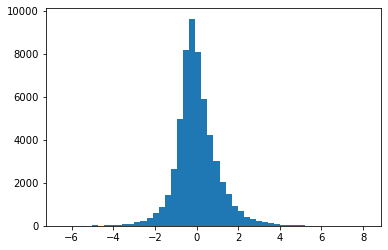

In [325]:
plt.hist(dtd_df["delta_td"], bins=50)
plt.show()

In [326]:
dtd_df['z_scores'] = (dtd_df['delta_td'] - dtd_df['delta_td'].mean()) / dtd_df['delta_td'].std()

#pbs_df.dropna()

dtd_df['p_values'] = stats.norm.sf(abs(dtd_df['z_scores'])) *2
alpha = 0.05
bonferroni_corrected_alpha = alpha / len(dtd_df)
dtd_df['significant'] = dtd_df['p_values'] < bonferroni_corrected_alpha
dtd_df.to_csv("delta_tajimas_d.csv", index=False, sep=",", header=True)

In [327]:
dtd_df[dtd_df['significant']]

,chrom,start,stop,delta_td,n_snps,z_scores,p_values,significant
453,NC_067196.1,4306982,4310776,5.899610,500,5.899558,3.644757e-09,True
592,NC_067196.1,5320719,5325714,-6.498641,500,-6.498584,8.107929e-11,True
593,NC_067196.1,5325715,5330093,-5.425276,500,-5.425229,5.788032e-08,True
663,NC_067196.1,5750364,5755640,-5.036281,500,-5.036237,4.747734e-07,True
667,NC_067196.1,5770308,5774518,-5.015626,500,-5.015582,5.287322e-07,True
...,...,...,...,...,...,...,...,...
3597,NC_067202.1,16492546,16496875,-6.300109,500,-6.300054,2.975414e-10,True
3600,NC_067202.1,16508452,16512444,-5.974493,500,-5.974441,2.308804e-09,True
3604,NC_067202.1,16523617,16527869,-5.225052,500,-5.225006,1.741490e-07,True
3647,NC_067202.1,16703750,16708592,-5.415595,500,-5.415548,6.110134e-08,True


In [9]:
len(sel_df)

28585163